In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
import cv2
import os

In [60]:
base_dir = r"C:\BeCode\computervisionData\HAM10000_skin_mnist"
metadata = base_dir + "/HAM10000_metadata.csv"
img_dir = base_dir + "/HAM10000_images"

In [61]:
df = pd.read_csv(metadata)

Load images from img_dir given the name from metadata image_id, resized

In [62]:
images = []
img_ids = df['image_id'].to_list()
for id in img_ids:
    image = cv2.imread(os.path.join(img_dir, id + ".jpg"))
    image = cv2.resize(image, (128, 128))
    images.append(image)
images = np.array(images)

In [63]:
y = df['dx']
x = images


Encoding labels as catagory using sklearn labelEncoder

In [64]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

print(le.classes_)
print(np.unique(y))




['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0. 1.]


In [65]:
le.classes_

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [66]:
img_train, img_test, label_train, label_test = train_test_split(images, y, test_size=0.25, random_state=42)

In [67]:
np.unique(label_train)

array([0., 1.], dtype=float32)

In [68]:
np.unique(label_test)

array([0., 1.], dtype=float32)

Augmented image generator for train datasets to sove the imbalanced label problem

In [69]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


In [70]:
test_datagen = ImageDataGenerator(rescale=1./255)

Building and compile CNN model using keras

In [71]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
print(len(img_train))
print(len(img_test))
print(len(label_train))
print(len(label_test))

7511
2504
7511
2504


Train the model

In [75]:
history = model.fit_generator(
    train_datagen.flow(img_train, label_train, batch_size=32),
    steps_per_epoch=len(img_train) / 32, epochs=15,
    validation_data=test_datagen.flow(img_test, label_test),
    validation_steps=len(img_test) / 32)

# evaluate
test_loss, test_acc = model.evaluate(img_test, label_test, verbose=0)
print("Test accuracy:", test_acc)



C:\Users\genet\AppData\Local\Temp\ipykernel_13740\87323972.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
234/234 [==============================] - 297s 1s/step - loss: 0.9905 - accuracy: 0.6709 - val_loss: 0.9350 - val_accuracy: 0.6661
Epoch 2/15
234/234 [==============================] - 291s 1s/step - loss: 0.9664 - accuracy: 0.6702 - val_loss: 0.9764 - val_accuracy: 0.6661
Epoch 3/15
234/234 [==============================] - 292s 1s/step - loss: 0.9589 - accuracy: 0.6710 - val_loss: 0.8913 - val_accuracy: 0.6621
Epoch 4/15
234/234 [==============================] - 291s 1s/step - loss: 0.9094 - accuracy: 0.6754 - val_loss: 0.8607 - val_accuracy: 0.6689
Epoch 5/15
234/234 [==============================] - 291s 1s/step - loss: 0.8725 - accuracy: 0.6810 - val_loss: 0.8195 - val_accuracy: 0.6925
Epoch 6/15
234/234 [==============================] - 292s 1s/step - loss: 0.8579 - accuracy: 0.6837 - val_loss: 0.8442 - val_accuracy: 0.6921
Epoch 7/15
234/234 [==============================] - 293s 1s/step - loss: 0.8481 - accuracy: 0.6877 - val_loss: 0.8070 - val_accuracy: 0.6973

Generate the model's performance as a classification report

In [76]:
y_pred = model.predict(img_test/255)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(label_test, axis=1)


79/79 [==============================] - 23s 284ms/step


In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.07      0.11        86
           1       0.50      0.23      0.31       114
           2       0.36      0.51      0.43       285
           3       0.00      0.00      0.00        32
           4       0.47      0.37      0.41       292
           5       0.85      0.91      0.88      1668
           6       0.81      0.48      0.60        27

    accuracy                           0.72      2504
   macro avg       0.46      0.37      0.39      2504
weighted avg       0.70      0.72      0.71      2504



c:\BeCode\LocalRepos\VirtualEnvs\challenge_mole\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\BeCode\LocalRepos\VirtualEnvs\challenge_mole\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\BeCode\LocalRepos\VirtualEnvs\challenge_mole\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

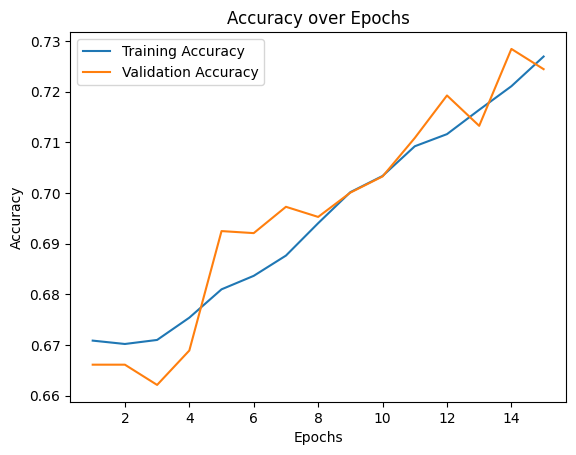

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(range(1, 16), acc, label='Training Accuracy')
plt.plot(range(1, 16), val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


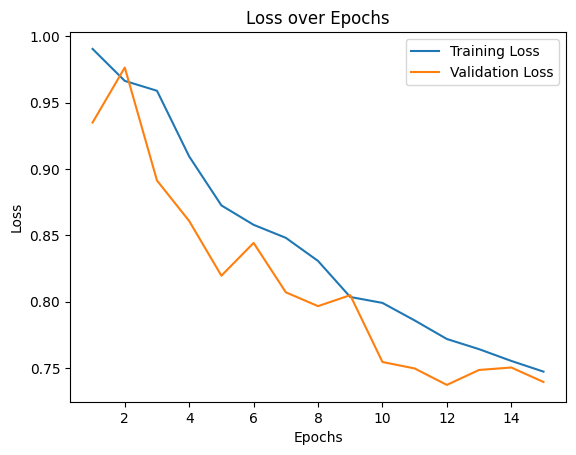

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(1, 16), loss, label='Training Loss')
plt.plot(range(1, 16), val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Finally save the model in the current directory

In [99]:
model.save('model_keras.h5')

Test the model from external input image by loading the model from the file

In [95]:
img_test_ex = cv2.imread(os.path.join(img_dir, "ISIC_0024327.jpg"))
img_test_ex = cv2.resize(img_test_ex, (128,128))
img_test_ex = np.array(img_test_ex/255.0)
img_test_ex = np.expand_dims(img_test_ex, axis=0)

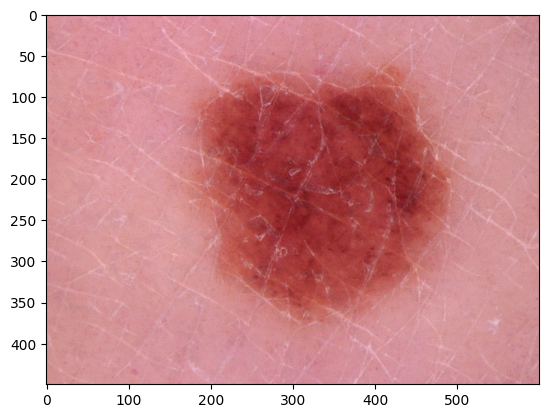

In [93]:
plt.imshow(img_test_ex)
plt.show()

In [96]:
# result =  model.predict(img_test_ex)
img_test_ex = np.expand_dims(images[0], axis=0)
result =  model.predict(img_test_ex)



1/1 [==============================] - 0s 148ms/step


In [97]:

if  ((result == 'nv') | (result == 'bkl') | (result == 'df') | (result == 'vasc')):
    print("the images looks of no concern, not cancerous")
else:
    print("the image is classified as cancerous mole and needs medical attention")


the image is classified as cancerous mole and needs medical attention


C:\Users\genet\AppData\Local\Temp\ipykernel_13740\2763124389.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if  ((result == 'nv') | (result == 'bkl') | (result == 'df') | (result == 'vasc')):
